# Conditional Data Imputers

This example notebook demonstrates the usage and performance of `GaussianImputer` and `GaussianCopulaImputer` in the context of conditional imputation of Shapley interaction values and model-agnostic explanations. Two Conditional imputations modules are implemented as part of the `student_shapiq` package.

### Gaussian Imputer
For nice-behaving unimodal data, a natural approach is to assume that $x$ stems from a multivariate Gaussian distribution with mean $µ$ and covariance matrix $Σ$. In the present context, this method was first suggested by [(Aas et al. (2021))](https://doi.org/10.1016/j.artint.2021.103502).

### Gaussian Copula Imputer
A generalization of the gaussian approach, also proposed by [(Aas et al. (2021))](https://doi.org/10.1016/j.artint.2021.103502), is to use a Gaussian copula. That is, to represent the marginals of the features by their empirical distributions and then model the dependence structure by a Gaussian distribution.

### Import Modules


In [1]:
from __future__ import annotations

import shapiq
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import shapiq_student
from shapiq_student.gaussian import GaussianImputer

print(f"shapiq version: {shapiq.__version__}")
print(f"shapiq_student version: {shapiq_student.__version__}")

shapiq version: 1.3.0
shapiq_student version: 0.4.1


We firstly use California housing dataset for demonstration. Dataset can be found at https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [2]:
X, y = shapiq.load_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values,
    test_size=0.25,
    random_state=42,
)
n_features = X_train.shape[1]

print("Feature names:")
print(X.columns.tolist())

Feature names:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


### Train a Model
We train a random forest regressor on the California housing dataset to explain the model with conditional imputation. The model achieves a relatively good fit in terms of the $R^2$ score.

In [3]:
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=n_features,
    max_features=2 / 3,
    max_samples=2 / 3,
    random_state=42,
)
model.fit(X_train, y_train)
print(f"Train R2: {model.score(X_train, y_train):.4f}")
print(f"Test  R2: {model.score(X_test, y_test):.4f}")

Train R2: 0.7991
Test  R2: 0.7462


### Using multivariate Gaussian or Gaussian Copula Imputer for Explanations
We initialize multivariate gaussian or gaussian copula imputer and pass it to the explainer. We firstly wrap the function with a predict function, so it can work with the shapiq API.

In [4]:
class PredictWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, X):
        return self.model.predict(X)


wrapped_model = PredictWrapper(model)

gaussian_imputer = GaussianImputer(model=wrapped_model, data=X_test)
# gaussian_copula_imputer = GaussianCopulaImputer(model=wrapped_model, data=X_test)

explainer = shapiq.TabularExplainer(
    # attributes of the explainer
    model=model,
    data=X_train,
    index="SII",
    max_order=2,

    # attributes of the imputer
    imputer="conditional",
    # imputer=gaussian_copula_imputer
    sample_size=100,
    conditional_budget=32,
    conditional_threshold=0.04,
)

Both Multivariate Gaussian and Gaussian Copula Imputers use the joint distribution of features to estimate missing values, but in different ways. The Multivariate Gaussian Imputer assumes all variables follow a joint Gaussian distribution, modeling both marginals and dependencies parametrically.

### Gausian Multivariate
A classic and beneficial property of this assumption is that the conditional distributions are also multivariate Gaussian. That is, if

$p(x) = p(x_S,x_{\overline{S}}) = \mathcal{N}_M(µ,Σ)$, where $µ = [µ_S,µ_{\overline{S}}]^T$ and
$$
\Sigma = \begin{bmatrix}
\Sigma_{S,S} & \Sigma_{S,\overline{S}} \\
\Sigma_{\overline{S},S} & \Sigma_{\overline{S},\overline{S}}
\end{bmatrix}
$$
then, $p(x_\overline{S}|x_S = x^{∗}_S) = \mathcal{N}_{|\overline{S}|}(µ_{\overline{S}|S},Σ_{\overline{S}|S})$, where
$µ_{\overline{S}|S} = µ_{\overline{S}} + Σ_{\overline{S}S}Σ_{SS}^{-1}(x^{∗}_S − µ_S)$ and
$Σ_{\overline{S}|S} = Σ_{\overline{SS}}-Σ_{\overline{S}S}Σ_{SS}^{-1}Σ_{S\overline{S}}$. The parameters $µ$ and $Σ$ are easily estimated using, respectively, the sample mean and covariance matrix of the training data.

### Gaussian Copula
A generalization of the _gaussian_ approach, which is, to represent the marginals of the features by their empirical distributions and then model the dependence structure by a Gaussian distribution. This _copula_ approach generates the $K$ conditional Monte Carlo samples
$x_{\overline{S}}^{(k)} \sim  p(x_{\overline{S}}|x_S = x^{*}_{S})$ with the following routine:

1. Convert each marginal $x_j$ of the feature distribution $x$ to a Gaussian distributed variable $v_j$ by $v_j = Φ^{−1}(\hat{F}(x_j))$, where
$ \hat{F}(x_j)$ is the empirical distribution function of $x_j$.
2. Assume that $v$ is distributed according to a _multivariate Gaussian_, and sample from the conditional distribution $p(v_{\overline{S}}|v_{S} = v^{∗}_S)$ using the method described for the gaussian approach.
3. Convert the marginals $v_j$ in the conditional distribution to the original distribution using $\hat{x}_j = \hat{F}^{−1}_j(Φ(v_j))$.



Next, select we an instance to be explained.

In [5]:
x_explain = X_test[100]

Call an `explain()` interface setting `random_state` for reproducible approximation.

In [6]:
interaction_values = explainer.explain(x_explain, budget=2**n_features, random_state=0)
print(interaction_values)

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=2.06997805874991,
    Top 10 interactions:
        (5,): 0.07380611267017625
        (0, 1): 0.0596087604477067
        (2,): 0.03475381093966788
        (5, 7): 0.027985525163259178
        (1, 7): -0.026695075662078658
        (1, 5): -0.02789824003743552
        (0, 7): -0.02919889288052874
        (1,): -0.13725001940693232
        (0,): -0.17756231448209567
        (7,): -0.18450352252236774
)


Visualize the explanation.

(<Figure size 700x700 with 1 Axes>, <Axes: >)

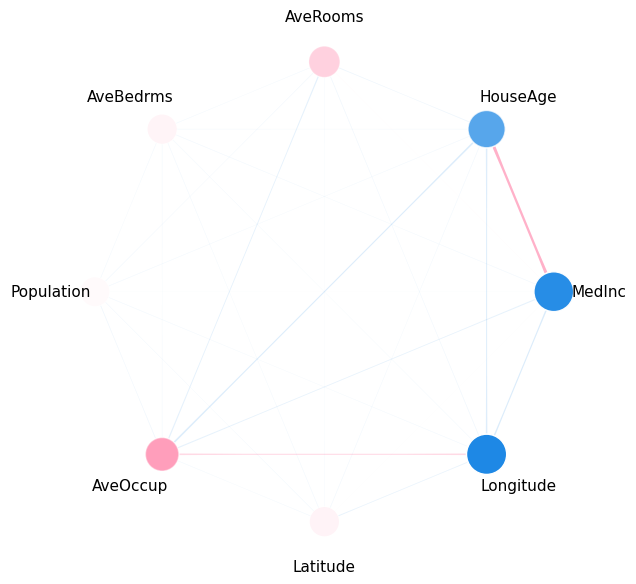

In [7]:
shapiq.network_plot(
    interaction_values=interaction_values,
    feature_names=X.columns,
)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='features', ylabel='SI values'>)

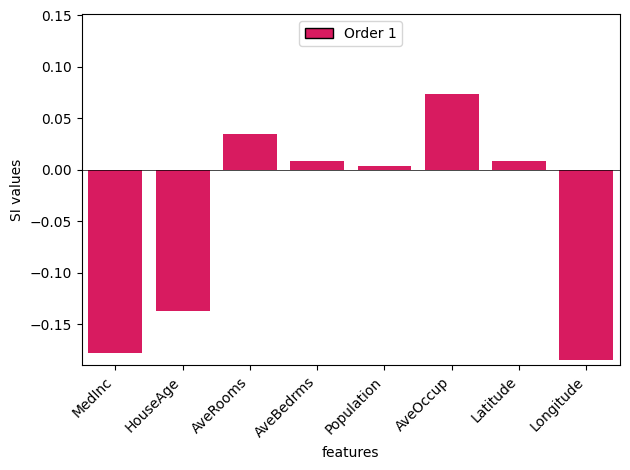

In [8]:
shapiq.stacked_bar_plot(
    interaction_values.get_n_order(1),
    feature_names=X.columns,
)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='features', ylabel='SI values'>)

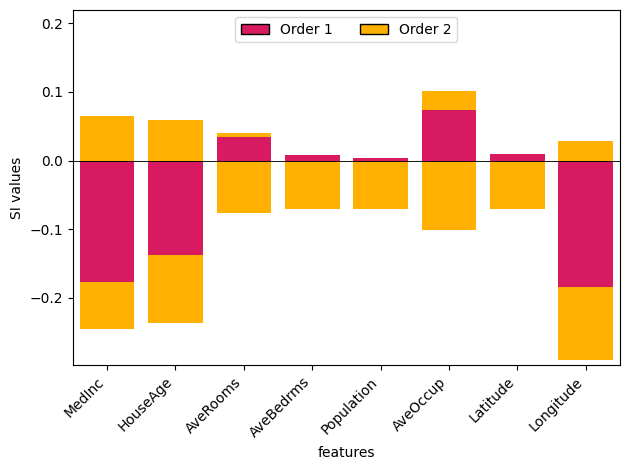

In [9]:
shapiq.stacked_bar_plot(
    interaction_values=interaction_values,
    feature_names=X.columns,
)

Visualize the Shapley values

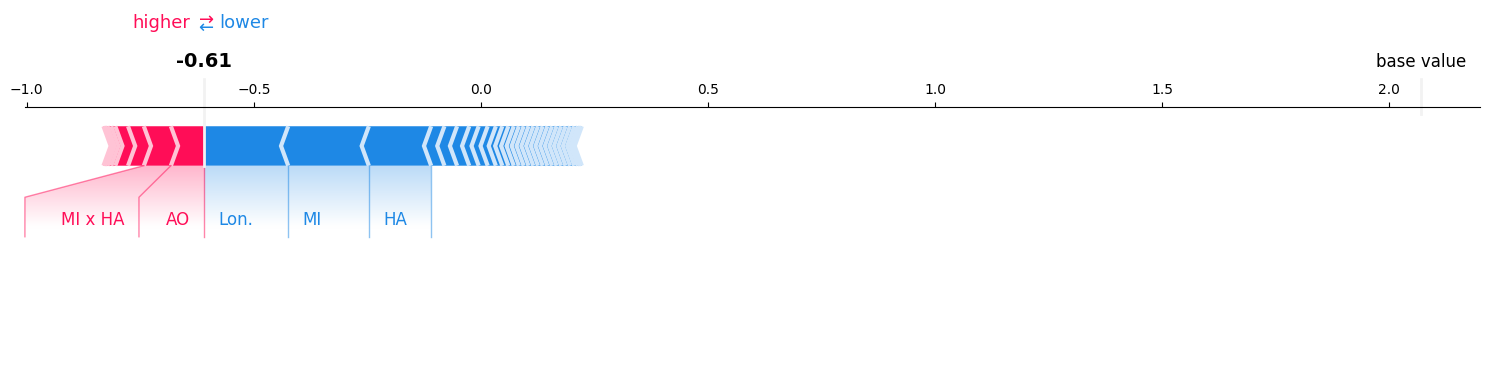

In [10]:
interaction_values.plot_force(feature_names=X.columns)